### Приложение доставки

Есть приложение по доставке продуктов. Была внедрена умная система рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен А/B-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. 

#### Данные

ab_users_data – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи\
ab_orders – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ\
ab_products – подробная информация о продуктах, их название и стоимость

По условию: команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.\
Нужно оценить принесла ли новая система рекомендаций пользу.

Можно рассмотреть несколько важных критериев для оценки эффективности новой системы рекомендации товаров:
 - изменилось ли число заказов на покупателя;
 - не увеличился ли процент отмены заказов ко всем заказам; 
 - увеличился ли ассортимент покупаемых товаров в среднем у покупателей;
 - изменилось ли количество  товаров в заказе

In [329]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import scipy
import seaborn as sns

import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal
import statsmodels.api as sa 

#import pingouin 

sns.set(rc = {'figure.figsize':(8,6)}, style = "whitegrid")

In [330]:
df_users = pd.read_csv('ab_users_data.csv')

In [331]:
df_users.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [332]:
df_orders = pd.read_csv('ab_orders.csv')

In [333]:
df_orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [334]:
df_products = pd.read_csv('ab_products.csv')

In [335]:
df_products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


##### Предварительный анализ данных и предобработка данных

In [336]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4337 entries, 0 to 4336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   4337 non-null   int64 
 1   order_id  4337 non-null   int64 
 2   action    4337 non-null   object
 3   time      4337 non-null   object
 4   date      4337 non-null   object
 5   group     4337 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 203.4+ KB


In [337]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  87 non-null     int64  
 1   name        87 non-null     object 
 2   price       87 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ KB


In [338]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   order_id       4123 non-null   int64 
 1   creation_time  4123 non-null   object
 2   product_ids    4123 non-null   object
dtypes: int64(1), object(2)
memory usage: 96.8+ KB


In [339]:
# Изменяем тип для дат
df_users.date = pd.to_datetime(df_users.date)
df_users.time = pd.to_datetime(df_users.time)
df_orders.creation_time = pd.to_datetime(df_orders.creation_time)

In [340]:
# посмотрим сколько созданных и сколько из них отменено
df_users.action.value_counts()

action
create_order    4123
cancel_order     214
Name: count, dtype: int64

In [341]:
df_users.nunique()

user_id     1017
order_id    4123
action         2
time        4312
date          14
group          2
dtype: int64

In [342]:
df_products.describe()# нет отрицательных цен

,product_id,price
count,87.000000,87.000000
mean,44.000000,133.581609
std,25.258662,136.127922
min,1.000000,1.000000
25%,22.500000,55.000000
50%,44.000000,76.300000
75%,65.500000,160.000000
max,87.000000,800.000000


In [343]:
# смотрим даты проведения теста
df_users.describe(include = 'datetime')

,time,date
count,4337,4337
mean,2022-08-30 14:39:09.155909632,2022-08-30 00:44:49.416647680
min,2022-08-26 00:00:19,2022-08-26 00:00:00
25%,2022-08-26 20:14:06,2022-08-26 00:00:00
50%,2022-08-29 12:37:48,2022-08-29 00:00:00
75%,2022-09-02 20:43:41,2022-09-02 00:00:00
max,2022-09-08 23:41:24,2022-09-08 00:00:00


In [344]:
# оценим соотношения пользователей в группах (сколько пользователей попало в каждую группу)
# старая версия приложения
df_users.query('group == 0').user_id.nunique()

515

In [345]:
# новая версия приложения 
df_users.query('group == 1').user_id.nunique()

502

Количество человек, участвующих в тесте незначительно отличаются в двух группах.

In [346]:
# определим сколько наименований товаров в каждом заказе и поместим в новую колонку - product_count
df_orders['product_ids'] = df_orders.product_ids.apply(lambda x:   (x.strip("{}").split(",")) )
df_orders['product_count'] = df_orders.product_ids.apply(lambda x:   len(x) )

In [347]:
# определим сколько различных товаров в каждом заказе
df_orders['product_assort'] = df_orders.product_ids.apply(lambda x:   len(list(set(x))) )

In [348]:
df_orders

,order_id,creation_time,product_ids,product_count,product_assort
0,1255,2022-08-26 00:00:19,"[75, 22, 53, 84]",4,4
1,1256,2022-08-26 00:02:21,"[56, 76, 39]",3,3
2,1257,2022-08-26 00:02:27,"[76, 34, 41, 38]",4,4
3,1258,2022-08-26 00:02:56,"[74, 6]",2,2
4,1259,2022-08-26 00:03:37,"[20, 45, 67, 26]",4,4
...,...,...,...,...,...
4118,59422,2022-09-08 23:13:03,"[84, 8, 24]",3,3
4119,59439,2022-09-08 23:18:05,"[9, 25, 75, 30, 6]",5,5
4120,59464,2022-09-08 23:22:27,"[60, 41, 46]",3,3
4121,59487,2022-09-08 23:29:06,"[9, 62, 77]",3,3


In [349]:
# объединим таблицу с историей заказов пользователей и таблицу с подробной информацией о составе заказа
df_users = df_users.merge(df_orders, on = 'order_id')

In [350]:
df_users

,user_id,order_id,action,time,date,group,creation_time,product_ids,product_count,product_assort
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19,"[75, 22, 53, 84]",4,4
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21,"[56, 76, 39]",3,3
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,2022-08-26 00:02:27,"[76, 34, 41, 38]",4,4
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,2022-08-26 00:02:56,"[74, 6]",2,2
4,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0,2022-08-26 00:02:56,"[74, 6]",2,2
...,...,...,...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1,2022-09-08 23:13:03,"[84, 8, 24]",3,3
4333,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1,2022-09-08 23:18:05,"[9, 25, 75, 30, 6]",5,5
4334,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0,2022-09-08 23:22:27,"[60, 41, 46]",3,3
4335,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0,2022-09-08 23:29:06,"[9, 62, 77]",3,3


### Анализ

Посмотрим как изменилось  количество заказов и количество отмен заказов в группе с новым алгоритмом.


Построим график соотношения созданных (create_order) и отмененных (cancel_order) заказов в двух группах


<Axes: xlabel='group', ylabel='count'>

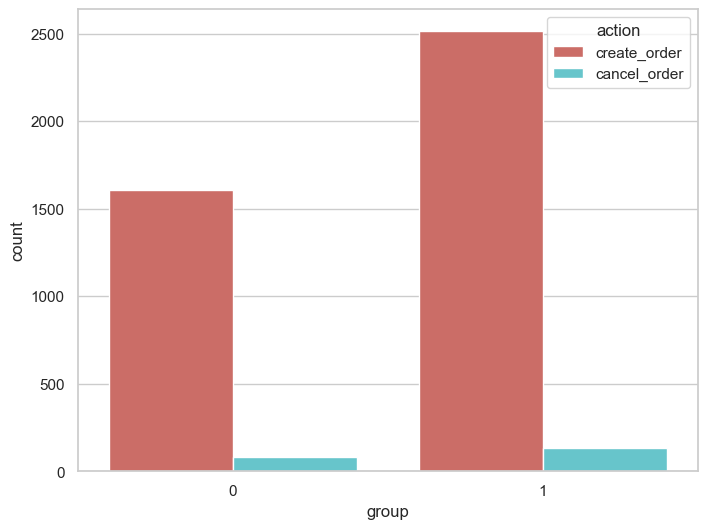

In [351]:
sns.countplot(x = df_users.group, hue = df_users.action, palette = 'hls')

Количество заказов  в группе с умной системой рекомендации товаров существенно увеличилось, но также увеличилось и количество отмененных заказов. Проверим влияет ли новый алгоритм на увеличение отмен заказов.

Гипотеза: есть ли взаимосвязь между  группой и  отменами.

Проверим нашу гипотезу с помощью статистического теста.

Есть две категориальные переменные → нужен хи-квадрат\
𝐻0 : взаимосвязи между переменными нет\
𝐻1 : взаимосвязь есть

In [352]:
f = pd.crosstab(df_users.group, df_users.action)

In [353]:
stat, p, dof, expected = chi2_contingency(f) 

In [354]:
stat, p 

(0.018211165651942023, 0.8926523935841298)

In [355]:
prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


Вывод: значение p-value больше уровня значимости. Нулевая гипотеза НЕ ОТКЛОНЯЕТСЯ. Это означает, что между группой и отменой заказов нет взаимосвязи. Процент отмен не зависит от группы.

In [356]:
# посчитаем процент отмен в группе до обновления
round(df_users.query("group == 0 & action == 'cancel_order'")\
.order_id.count()/df_users.query("group == 0 & action == 'create_order'").order_id.count(),2) * 100

5.0

In [357]:
# посчитаем процент отмен в группе после обновления
round(df_users.query("group == 1 & action == 'cancel_order'")\
.order_id.count()/df_users.query("group == 1 & action == 'create_order'").order_id.count(),2) * 100

5.0

Мы видим, что процент количества отмен в обеих группах одинаков и не зависит от группы

##### Проведем преобразование таблицы

Данные в колонке action  принимают одно из двух значений - создан или отменен заказ, преобразуем таблицу с помощью pivot, чтобы значения из action стали новыми колонками, а затем поместим в них значение колонки product_count (сколько наименований товаров в каждом заказе). Таким образом, получим таблицу, в которой каждому заказу будет соответствовать одна строка, при этом в колонке create_order будет стоять число наименований товаров этого заказа, а колонка cancel_order будет заполнена(число наименований товаров этого заказа), если заказ отменен.

In [358]:
df_users = df_users\
        .groupby(['user_id','order_id','date','group','action','product_count','product_assort'], as_index = False)\
        .product_ids.count()\
        .pivot(index = ['user_id','order_id','date','group','product_assort'], columns = 'action', values = 'product_count')\
        .reset_index()


In [359]:
df_users

action,user_id,order_id,date,group,product_assort,cancel_order,create_order
0,964,1255,2022-08-26,0,4,NaN,4.0
1,964,1257,2022-08-26,0,4,NaN,4.0
2,965,1256,2022-08-26,1,3,NaN,3.0
3,965,3946,2022-08-27,1,4,NaN,4.0
4,965,9097,2022-08-29,1,6,NaN,6.0
...,...,...,...,...,...,...,...
4118,1980,57384,2022-09-08,1,3,NaN,3.0
4119,1980,57498,2022-09-08,1,4,NaN,4.0
4120,1980,58430,2022-09-08,1,6,NaN,6.0
4121,1980,58460,2022-09-08,1,3,NaN,3.0


In [360]:
# удалим отмененные заказы
df_users_create = df_users.query("cancel_order-create_order != 0")
df_users_create = df_users_create.rename(columns = {'create_order':'product_count'})

In [361]:
df_users_create.head()

action,user_id,order_id,date,group,product_assort,cancel_order,product_count
0,964,1255,2022-08-26,0,4,NaN,4.0
1,964,1257,2022-08-26,0,4,NaN,4.0
2,965,1256,2022-08-26,1,3,NaN,3.0
3,965,3946,2022-08-27,1,4,NaN,4.0
4,965,9097,2022-08-29,1,6,NaN,6.0


In [362]:
df_users_create.shape

(3909, 7)

#### Проверим изменилось ли число заказов (неотмененных) на покупателя

In [363]:
# посчитаем количество неотмененных заказов по покупателям и группам

df_order_ = df_users_create.groupby(['user_id','group'], as_index = False)\
            .agg({'order_id':'count'})
df_order_ = df_order_.rename(columns = {'order_id':'order_count'})

In [364]:
df_order_.head()

action,user_id,group,order_count
0,964,0,2
1,965,1,9
2,967,1,5
3,968,0,3
4,969,0,2


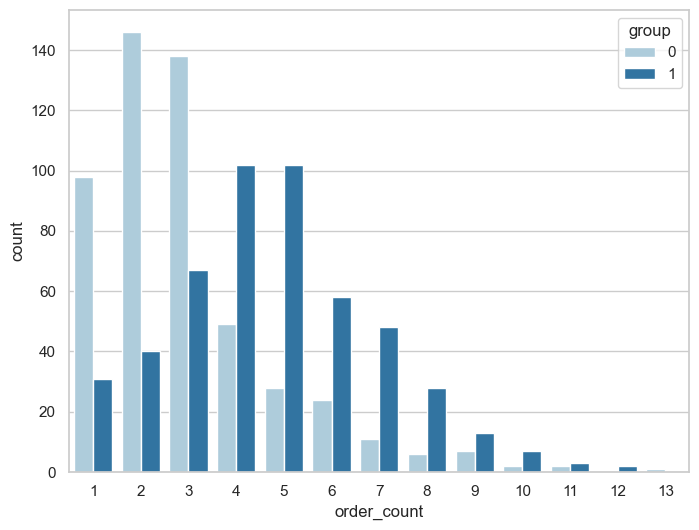

In [365]:
# график распределения заказов по дням и группам
ax = sns.countplot( x = df_order_.order_count, hue = df_order_.group.astype( 'str'), palette = 'Paired')
plt.show()

<Axes: xlabel='group', ylabel='order_count'>

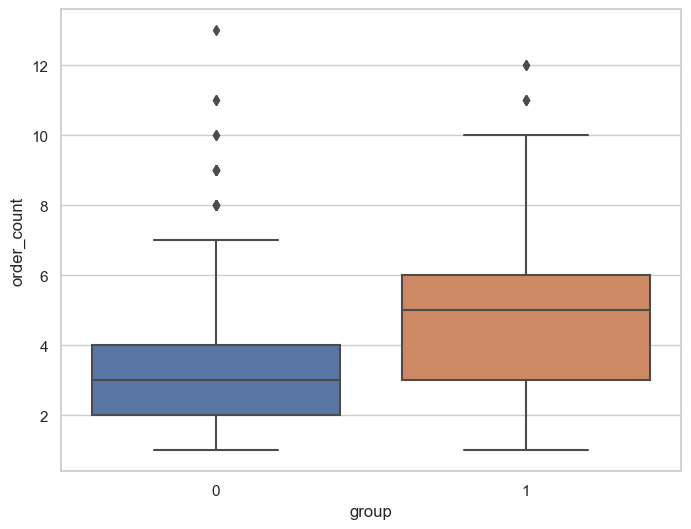

In [366]:
sns.boxplot(x = "group", y = "order_count", data = df_order_) 

Гипотеза: количество неотмененных заказов в  группе с умной системой рекомендации товаров изменилось.

Метрика - средние количества заказов.

𝐻0 : статистически значимых различий в средних нет\
𝐻1 : статистически значимые различия в средних есть

In [367]:
ss.ttest_ind(df_order_.query("group == 0").order_count,df_order_.query("group == 1").order_count)

TtestResult(statistic=-13.993124788985595, pvalue=8.430777321728061e-41, df=1011.0)

Интерпретируем результат:
значение p-value меньше уровня значимости. Нулевая гипотеза  ОТКЛОНЯЕТСЯ - есть статистически значимые различия у средних количеств заказов разных групп. 

Вывод : количество неотмененных заказов в группах статистически значимо различаются и, судя по графику, в группе с умной системой рекомендации товаров количество заказов увеличилось.

#### Проанализируем увеличился ли ассортимент товаров у пользователей в разных группах

In [368]:
#  группируем по пользователю, группам  и суммируем по ассортименту
df = df_users_create.groupby(['user_id','group'], as_index = False).agg({'product_assort' : 'sum'})

In [369]:
df.head()

action,user_id,group,product_assort
0,964,0,8
1,965,1,33
2,967,1,18
3,968,0,11
4,969,0,8


Построим графики 

<Axes: xlabel='group', ylabel='product_assort'>

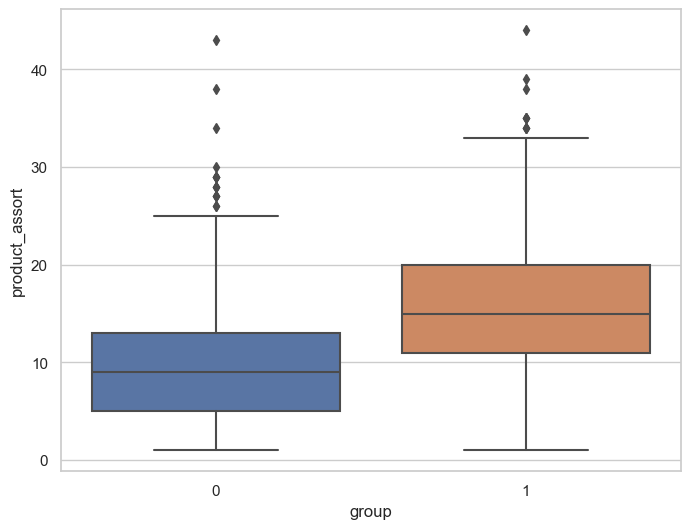

In [371]:
sns.boxplot(x = "group", y = "product_assort", data = df) 

/var/folders/m3/syl5j3ys2v570wpqnv0669s80000gp/T/ipykernel_1365/3980271074.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df.query("group == 0").product_assort, kde = False,bins = 40)
/var/folders/m3/syl5j3ys2v570wpqnv0669s80000gp/T/ipykernel_1365/3980271074.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe

<Axes: xlabel='product_assort'>

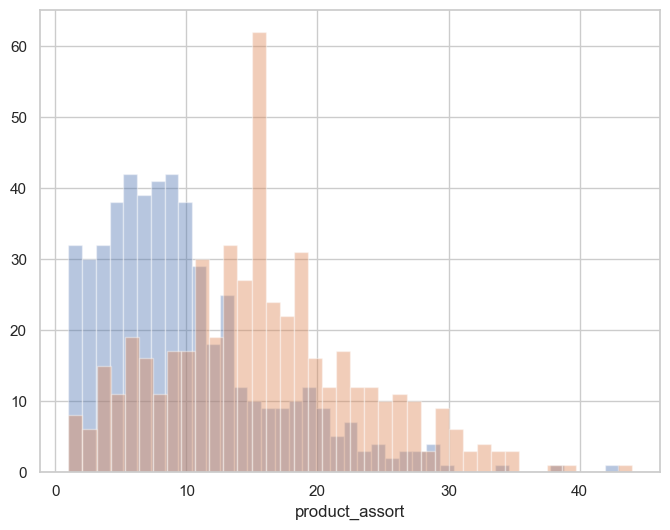

In [372]:
sns.distplot( df.query("group == 0").product_assort, kde = False,bins = 40)
sns.distplot( df.query("group == 1").product_assort, kde = False,bins = 40)

<Axes: xlabel='group', ylabel='product_assort'>

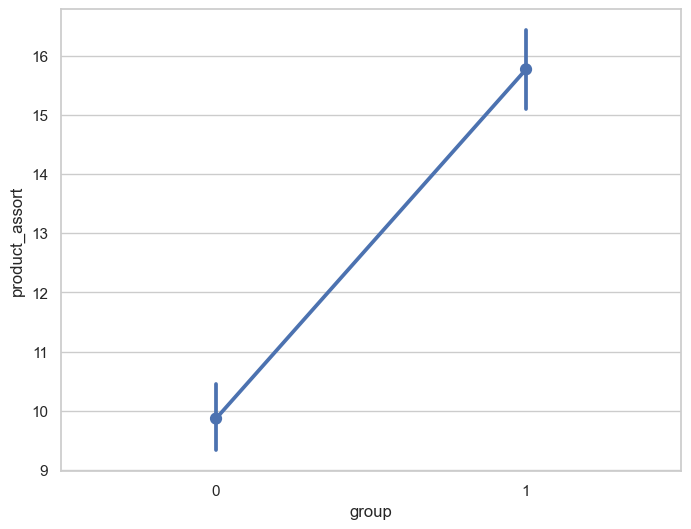

In [373]:
# средние  с доверительными интервалами

sns.pointplot(x = "group", y = "product_assort", data = df)

Боксплот: произошло смещение данных (среднего, медианы) группы с новым алгоритмом в сторону увеличения.\
Форма графика распределения сильно отличается  для двух групп, график данных  группы со старым алгоритмом имеет ассиметричный характер со смещением влево, а рспределение данных нового алгоритма имеет более равномерный характер.


Делать вывод только по графику – не очень хорошо, поэтому проверим нашу гипотезу с помощью статистического теста.

Тестируем нормальность:

- $H_0$: распределение нормально 
- $H_1$:  распределение не нормально 

In [374]:
scipy.stats.normaltest(df.query("group == 0").product_assort)

NormaltestResult(statistic=136.14031061781853, pvalue=2.7384648260294627e-30)

значение p-value сильно меньше уровня значимости. Нулевая гипотеза ОТКЛОНЯЕТСЯ - распределение не нормально

In [375]:
scipy.stats.normaltest(np.log(df.query("group == 1").product_assort))

NormaltestResult(statistic=90.04457624547673, pvalue=2.79942415511382e-20)

значение p-value сильно меньше уровня значимости. Нулевая гипотеза ОТКЛОНЯЕТСЯ - распределение не нормально

Тестируем различие в дисперсиях:
- $H_0$: дисперсия гомогенна
- $H_1$:  дисперсия не гомогенна

In [376]:
scipy.stats.levene(df.query("group == 0").product_assort,df.query("group == 1").product_assort)

LeveneResult(statistic=18.56703542177413, pvalue=1.8004558213796688e-05)

значение p-value меньше уровня значимости. Нулевая гипотеза  ОТКЛОНЯЕТСЯ - дисперсия не гомогенна

Гипотеза: ассортимент товаров у пользователей в  группе с умной системой рекомендации товаров и в группе со старым алгоритмом отличается в количественном вражении.

Метрика - распределение средних количеств наименований товаров  пользователя.

Есть две независимые количественные переменные, распределение групп не нормально и не гомогенны, поэтому применяем тест Манна Уитни\
𝐻0 : нет различий между распределениями выборок данных\
𝐻1 : есть различия между распределениями выборок данных

In [377]:
mannwhitneyu(df.query("group == 0").product_assort,df.query("group == 1").product_assort)

MannwhitneyuResult(statistic=66525.0, pvalue=3.3563394700189135e-40)

Интерпретируем результат:
значение p-value сильно меньше уровня значимости. Нулевая гипотеза   ОТКЛОНЯЕТСЯ - есть различия между распределениями выборок

Вывод : ассортимент товаров, купленных пользователями в группах статистически значимо различаются и, судя по графику, в группе с умной системой рекомендации ассортимент покупаемых товаров  увеличился.

#### Проанализируем изменилось ли количество товаров в заказе 

Построим графики

In [378]:
#  группируем по заказам, группам  и суммируем по количеству наименований товара
df = df_users_create.groupby(['order_id','group'], as_index = False).agg({'product_count':'sum'})

In [379]:
df.head()

action,order_id,group,product_count
0,1255,0,4.0
1,1256,1,3.0
2,1257,0,4.0
3,1259,1,4.0
4,1261,0,4.0


In [ ]:

sns.boxplot(x = "group", y = "product_count", data = df) 

In [ ]:
sns.distplot(df.query("group == 0").product_count, kde = False,bins = 8)
sns.distplot( df.query("group == 1").product_count, kde = False,bins = 8)

In [ ]:
# средние  с доверительными интервалами

sns.pointplot(x = "group", y = "product_count", data = df)

Проанализируем графики: \
Боксплот для двух групп одинаков.\
График распределений по форме одинаков для двух групп и отличается для групп только частотой встречаемости.


Делать вывод только по графику – не очень хорошо, поэтому проверим нашу гипотезу с помощью статистического теста.

In [ ]:
df.query("group == 0").product_count.describe()

In [ ]:
df.query("group == 1").product_count.describe()

Тестируем нормальность:

- $H_0$: распределение нормально 
- $H_1$:  распределение не нормально 

In [ ]:
scipy.stats.normaltest(df.query("group == 0").product_count)

значение p-value сильно меньше уровня значимости. Нулевая гипотеза ОТКЛОНЯЕТСЯ - распределение не нормально

In [ ]:
scipy.stats.normaltest(np.log(df.query("group == 1").product_count))

значение p-value сильно меньше уровня значимости. Нулевая гипотеза ОТКЛОНЯЕТСЯ - распределение не нормально

Тестируем различие в дисперсиях:
- $H_0$: дисперсия гомогенна
- $H_1$:  дисперсия не гомогенна

In [ ]:
scipy.stats.levene(df.query("group == 0").product_count,df.query("group == 1").product_count)

значение p-value больше уровня значимости. Нулевая гипотеза НЕ ОТКЛОНЯЕТСЯ - дисперсия  гомогенна

Гипотеза: нет отличий между количеством товаров в заказах в группе с умной системой рекомендации товаров и в группе со старым алгоритмом.

Метрика - распределение средних количества товаров в заказах.

Есть две независимые количественные переменные, распределение групп не нормально, дисперсия гомогенна → нужен тест Манна Уитни\
𝐻0 : нет различий между распределениями выборок данных\
𝐻1 : есть различия между распределениями выборок данных

In [ ]:
mannwhitneyu(df.query("group == 0").product_count,df.query("group == 1").product_count)

Интерпретируем результат:
значение p-value больше уровня значимости. Нулевая гипотеза  НЕ ОТКЛОНЯЕТСЯ - различий между распределениями выборок данных  нет

Можно попробовать применить t- тест. Условиями теста предусмотрено, что выборки должны быть независимы друг от друга (соблюдается), нормально распределены   или достаточно велики по объему. У нас нет нормального распределения, но выборки достаточно велики - попробуем применить t-тест.

Метрика - средние количеств наименований товаров в заказах.

𝐻0 : статистически значимых различий в средних нет\
𝐻1 : статистически значимые различия в средних есть

In [ ]:
ss.ttest_ind(df.query("group == 0").product_count,df.query("group == 1").product_count)

Интерпретируем результат:
значение p-value больше уровня значимости. Нулевая гипотеза  НЕ ОТКЛОНЯЕТСЯ - статистически значимых различий средних количества наименовний товаров в группах нет

Вывод : количество  товаров в одном заказе в группах статистически значимо не различаются, изменений нет.

После статистической проверки результатов А/В-теста получили, что при применении умной системы рекомендации товаров:
 - стат.значимо увеличилось количество заказов на покупателя;
 - процент отмен заказов стат.значимо не изменился;
 - стат.значимо увеличился ассортимент товаров в заказах пользователей;
 - количество товаров в одном заказе стат.значимо не изменилось.
 


Принимаем решение новую систему рекомендаций выкатывать на всех пользователей.